In [16]:
import librosa as lr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import logging

from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot  


class VoiceSamples(Dataset):
    
    def __init__(self, core_name, samples_path=None, Automatic=None):
        
        self.Log = logging.getLogger()
        logging.basicConfig(level=logging.INFO)
        
        self.noiseThreshold = 1
        
        self.core_name = core_name
        self.samples_path = samples_path
        
        self.soundSamples = []
        self.sampleRate = []
        
        self.chopedSamples = []
        self.chopedSr = []
        
        self.tensorMelgrams = []
        
        
        self.info = " VoiceSamples Object successfully created "
        self.Log.info(self.info)
        
        
        if Automatic:
            self.LoadSoundSamples()
            self.ChopToOneSecFragments()
            self.ChopedSignalsToTenosor()
        
    def __len__(self):
        return len(self.tensorMelgrams)
    
    def __getitem__(self, idx):
        if self.tensorMelgrams:
            return self.tensorMelgrams[idx]
    

    def LoadSoundSamples(self):
    
        n = 1

        while(True):
            try:
                if  self.samples_path:
                    path =  self.samples_path + self.core_name + str(n)
                else:
                    path = self.core_name + str(n)

                soundSample, sampleRate = lr.load(path)

                n += 1
                self.soundSamples.append(soundSample)
                self.sampleRate.append(sampleRate) 

                self.info = " Sample : " + path + " : successfully added"
                self.Log.info(self.info)

            except FileNotFoundError:
                if self.soundSamples:
                    self.info = "That's the end of database : " + str(n-1) + " : Samples added"
                    self.Log.info(self.info)
                    n = 0
                    
                    return self.soundSamples, self.sampleRate

                else:
                    self.Log.exception("Files are missing")
                    n = 0

                break

            except Exception as ex:      
                self.Log.exception("Unexpected error")
                break
        
    def getSoundSample(self, idx):
        return self.soundSamples[idx], self.sampleRate[idx]
    
    def getSoundSampleLen(self):
        try:
            if len(self.soundSamples) == len(self.sampleRate):
                return len(self.soundSamples)
            else:
                self.Log.warning("Lists: sundSamples and sampleRate are not equal!")
                
        except Exception as e:
            self.Log.exception("Unexpected error" + e)
    
    def ChopToOneSecFragments(self):
        
        # TODO: make shure user goes step by step 
        
        try:
            if len(self.soundSamples) == len(self.sampleRate):
                for idx in range(len(self.soundSamples)):
                    
                    soundSample = self.soundSamples[idx]
                    sr = self.sampleRate[idx]
                    
                    frag_max = math.trunc(len(soundSample)/float(sr))
                    step = math.trunc(sr/2);
                    last_sample = len(soundSample)

                    for frag in range(frag_max*2):
                        start = step * frag
                        stop = start + sr
                        if sr<len(soundSample):
                            if self.checkIfNotNoise(soundSample[start:stop]):
                                self.chopedSamples.append(soundSample[start:stop])
                                self.chopedSr.append(sr)
                                self.info = "Sample " + str(idx) + " : " + str(frag+1) + " : successfully choped and added"
                                self.Log.info(self.info)
                            else:
                                self.info = "Sample " + str(idx) + " : " + str(frag+1) + " : NOISE!"
                                self.Log.info(self.info)
                        else:
                            self.Log.warning("Something went wrong")
                            
                    if self.checkIfNotNoise(soundSample[last_sample-sr:last_sample]):
                         # incuding samples cuted by math.trunc() 
                        self.chopedSamples.append(soundSample[last_sample-sr:last_sample])
                        self.chopedSr.append(sr)
                        self.info = "Sample " + str(idx) + " : " + str(frag_max*2+1) + " : successfully choped and added"
                        self.Log.info(self.info)
                    else:
                        self.info = "Sample " + str(idx) + " : " + str(frag+1) + " : NOISE!"
                        self.Log.info(self.info)
                
                if self.chopedSamples:
                    self.Log.info("Sucessfully choped all loaded signals and eliminated the noise!")
                    return self.chopedSamples, self.chopedSr 
                    
            else:
                self.Log.warning("Lists: sundSamples and sampleRate are not equal!")
                
        except Exception as e:
            self.e = "Unexpected error : " + str(e)
            self.Log.exception(self.e)
            
    def getChoped(self, idx):
        return self.chopedSamples[idx], self.chopedSr[idx]
        
    def getChopedLen(self):
        try:
            if len(self.chopedSamples) == len(self.chopedSr):
                    return len(self.chopedSamples)
            else:
                self.Log.warning("Lists: sundSamples and sampleRate are not equal!")
                
        except Exception as e:
            self.Log.exception("Unexpected error" + e)
            
        
    def ChopedSignalsToTenosor(self):
        
        # TODO: make shure user goes step by step 
        
        try:
        
            if len(self.chopedSamples) == len(self.chopedSr):
                for idx in range(len(self.chopedSamples)):

                    # hop length adjusted
                    STFT_signal = np.abs(lr.stft(self.chopedSamples[idx], n_fft = 512, hop_length = round(self.chopedSr[idx]/256))) 
                    STFT_signal = lr.power_to_db(STFT_signal**2,ref=np.max)

                    Melgram = STFT_signal[0:256,0:256]
                    TMelgram = torch.tensor(Melgram)
                    self.tensorMelgrams.append(TMelgram)
                    
                    self.info = "ChopedSample " + str(idx) + " : " + " : converted to tensor"
                    self.Log.info(self.info)
                
                if self.tensorMelgrams:
                    self.Log.info("Sucessfully converted all ChopedSamples to Tensors!")
                    return self.tensorMelgrams
                
            else:
                self.Log.warning("Lists: chopedSamples and chopedSr are not equal!")
                
        except Exception as e:
            self.e = "Unexpected error : " + str(e)
            self.Log.exception(self.e)
                
    
    
    def checkIfNotNoise(self, chopedSample):
    
        chopedSamplePow2 = []

        for n in range(len(chopedSample)):
            chopedSamplePow2.append(chopedSample[n]**2)
        sk = sum(chopedSamplePow2)
        if sk > self.noiseThreshold:
            return True 
        else:
            return False
  
    
    
    


In [17]:
vs = VoiceSamples("vs", Automatic=True)
#vs.LoadSoundSamples()

INFO:root: VoiceSamples Object successfully created 
INFO:root: Sample : vs1 : successfully added
INFO:root: Sample : vs2 : successfully added
INFO:root:That's the end of database : 2 : Samples added
INFO:root:Sample 0 : 1 : successfully choped and added
INFO:root:Sample 0 : 2 : successfully choped and added
INFO:root:Sample 0 : 3 : successfully choped and added
INFO:root:Sample 0 : 4 : successfully choped and added
INFO:root:Sample 0 : 5 : successfully choped and added
INFO:root:Sample 0 : 6 : successfully choped and added
INFO:root:Sample 0 : 7 : successfully choped and added
INFO:root:Sample 0 : 8 : successfully choped and added
INFO:root:Sample 0 : 9 : successfully choped and added
INFO:root:Sample 0 : 10 : successfully choped and added
INFO:root:Sample 0 : 11 : successfully choped and added
INFO:root:Sample 0 : 12 : successfully choped and added
INFO:root:Sample 0 : 13 : successfully choped and added
INFO:root:Sample 0 : 14 : successfully choped and added
INFO:root:Sample 0 : 15 :

C:\Users\AXDition\Anaconda3_v2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


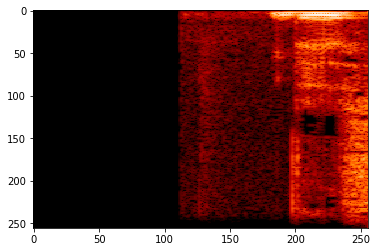

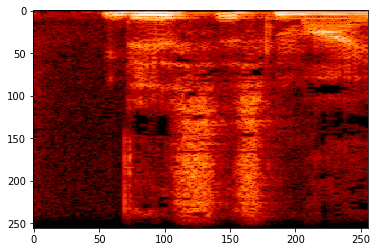

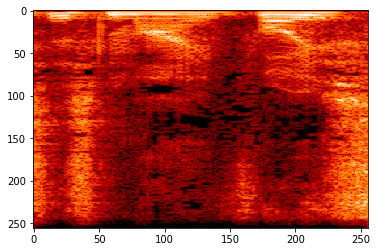

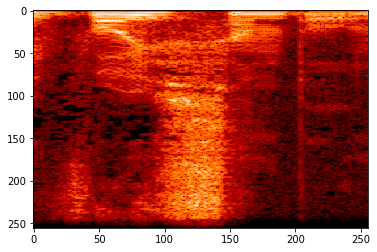

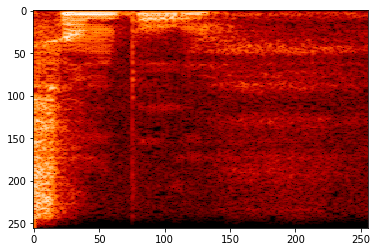

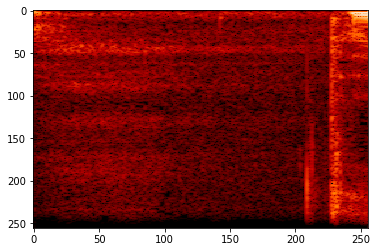

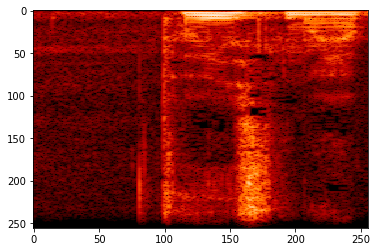

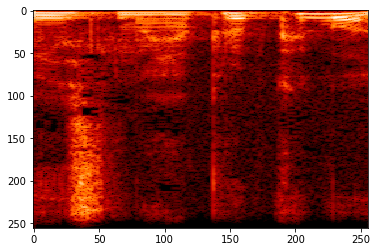

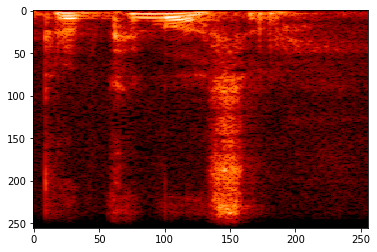

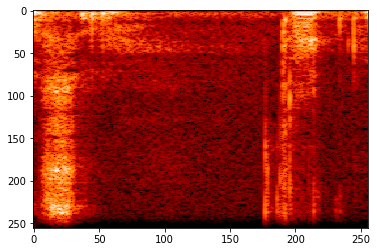

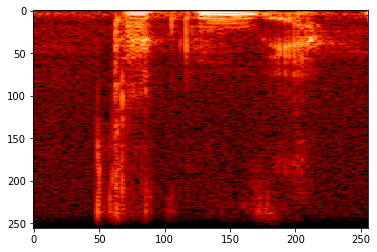

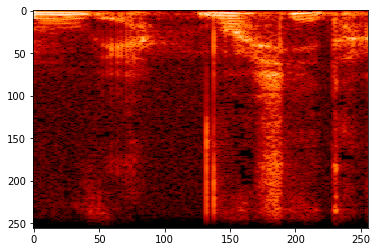

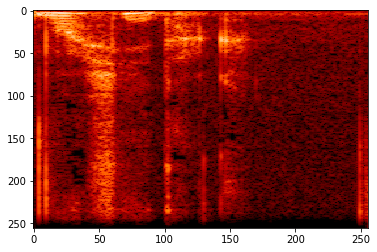

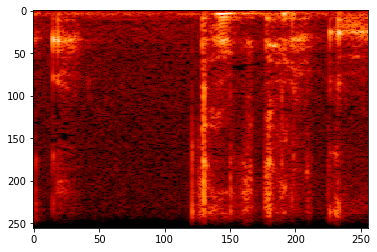

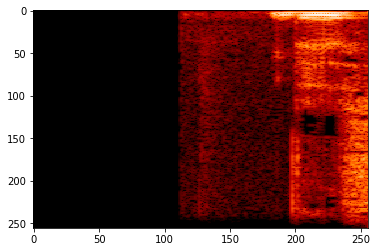

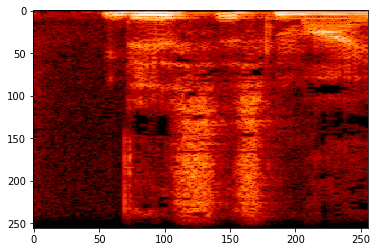

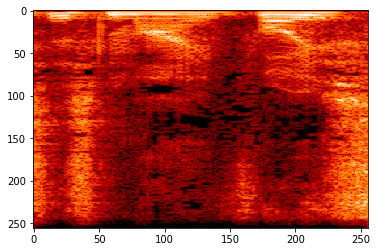

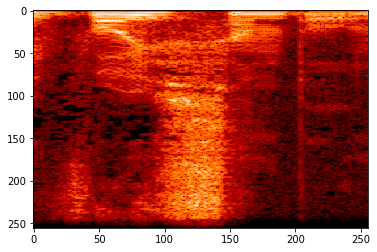

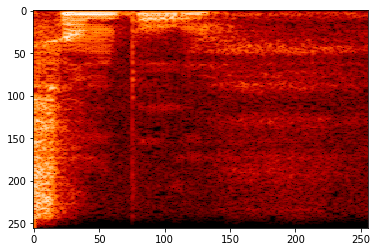

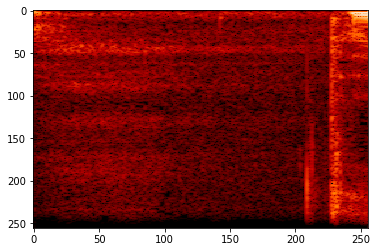

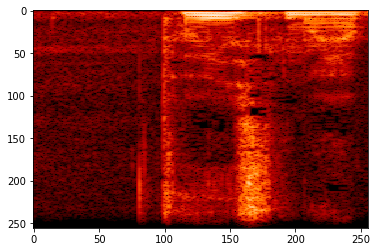

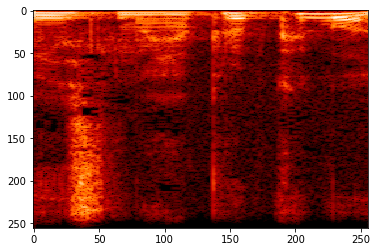

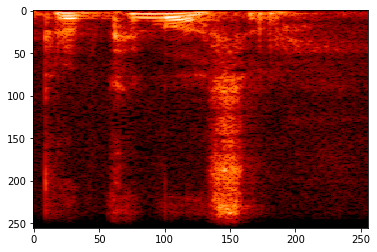

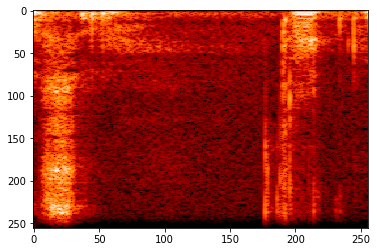

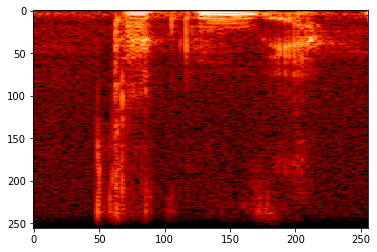

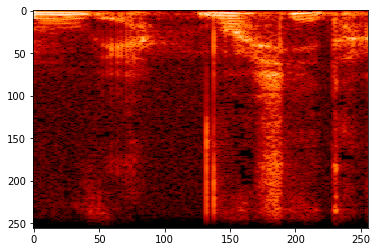

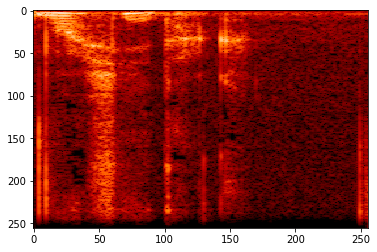

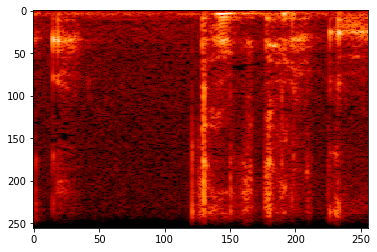

In [21]:
for i in range(len(vs)):
    pyplot.figure(i)
    pyplot.imshow(vs[i], cmap='gist_heat', aspect ='auto')
    

3.3784275350951427


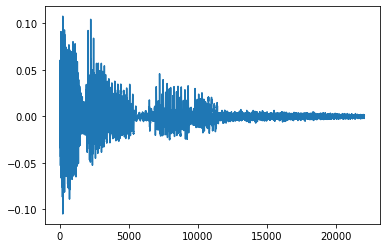

In [37]:
tt = vs.getChoped(4)[0]
pyplot.plot(tt)
chopedSamplePow2 = []

for n in range(len(tt)):
    chopedSamplePow2.append(tt[n]**2)
sk = sum(chopedSamplePow2)
print(sk)

C:\Users\AXDition\Anaconda3_v2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


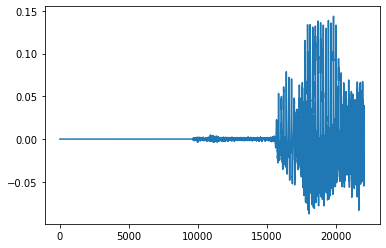

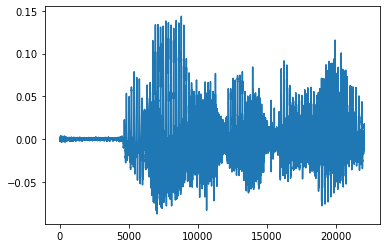

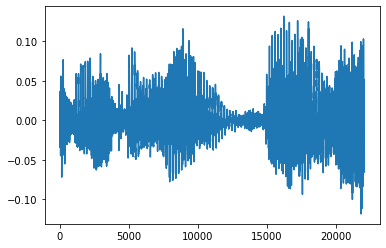

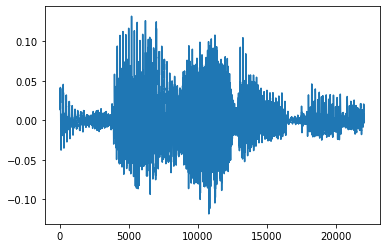

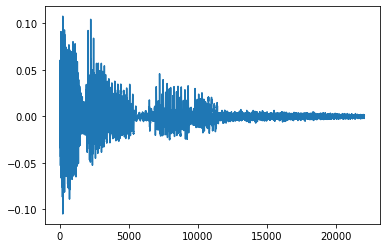

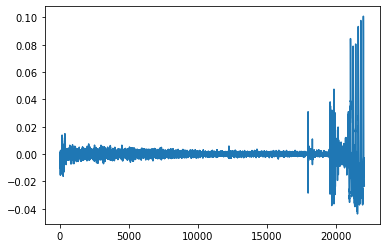

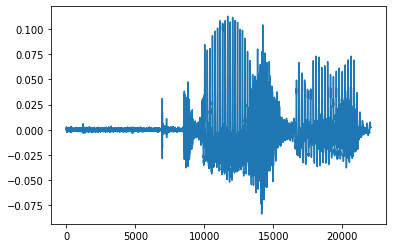

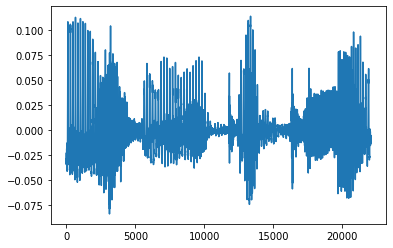

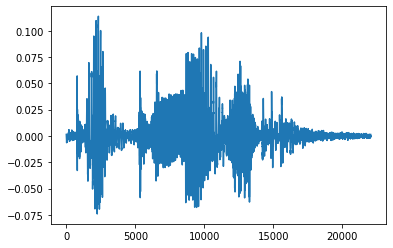

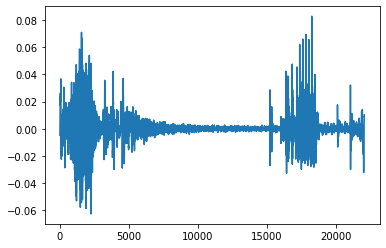

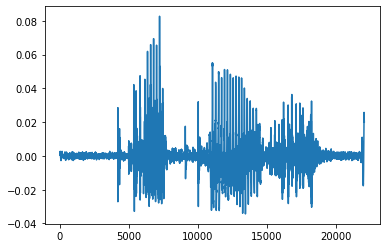

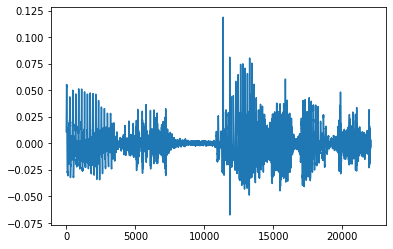

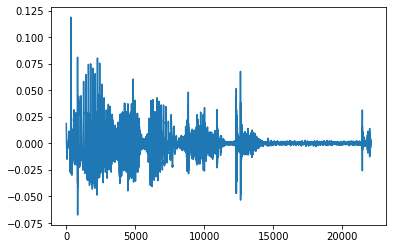

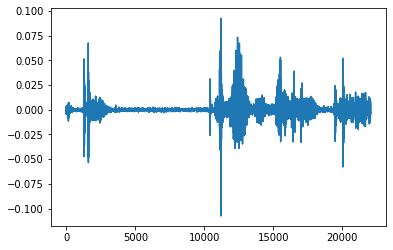

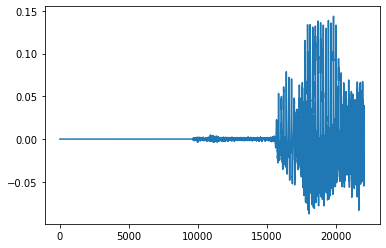

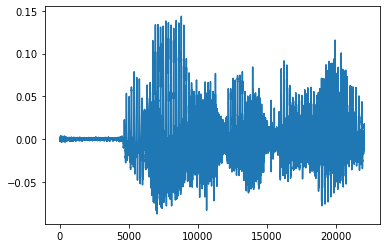

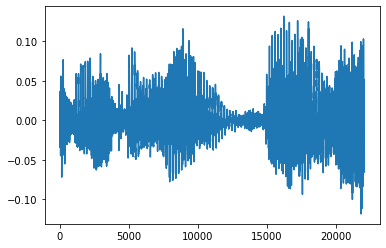

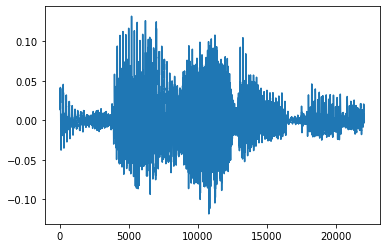

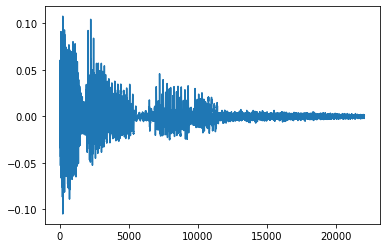

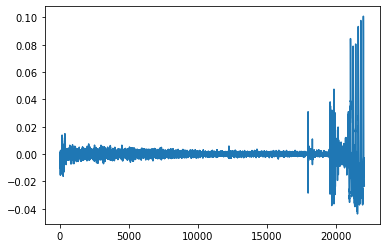

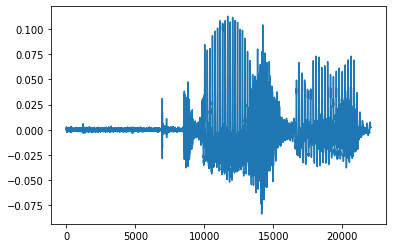

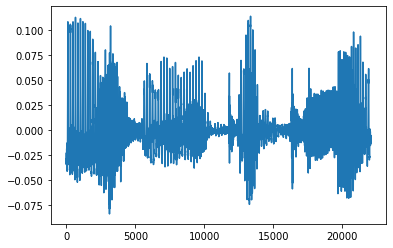

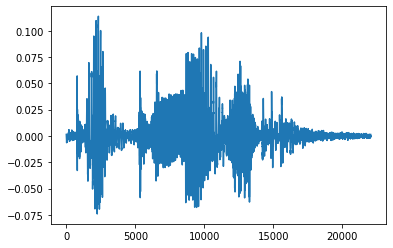

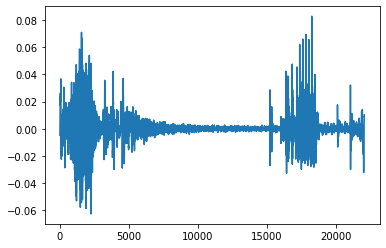

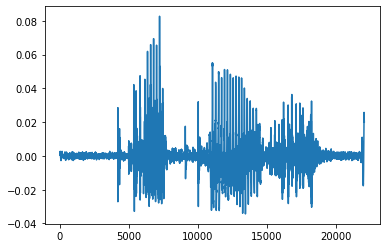

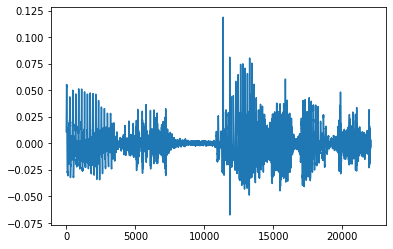

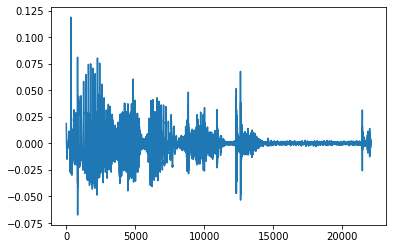

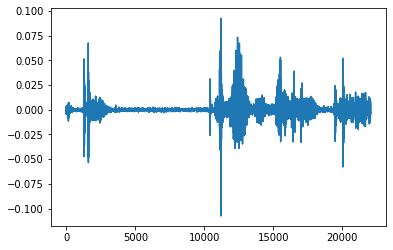

In [137]:
for idx in range(vs.getChopedLen()):
    chop, ch_sr =  vs.getChoped(idx)
    pyplot.figure(idx)
    pyplot.plot(chop)

9.584894087748257
7.059817493789973
8.63323454921216
3.358618695970616
0.05900926360048928
1.410387909548723
6.9401913839082345
6.467384059895168
0.970020352874716
0.5435145751951715
1.5668187085044398
2.5595079759004093
0.14868036267595078
0.9277971983336758
9.584894087748257
7.059817493789973
8.63323454921216
3.358618695970616
0.05900926360048928


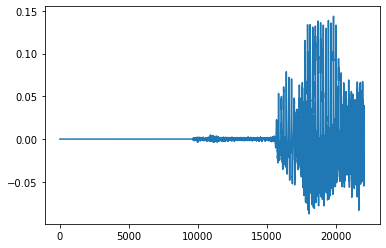

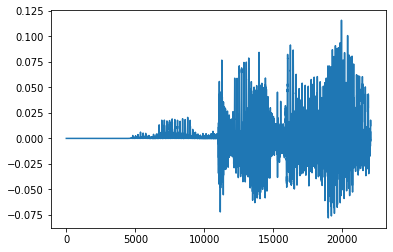

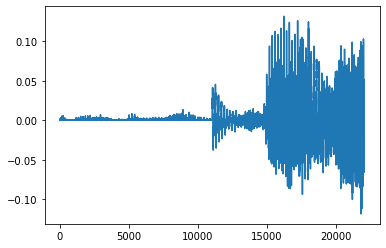

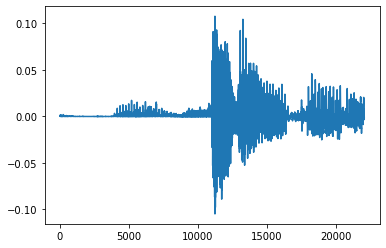

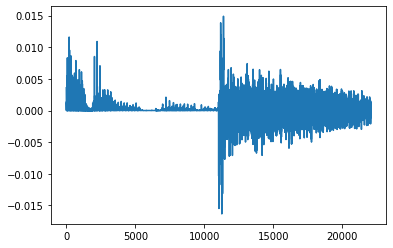

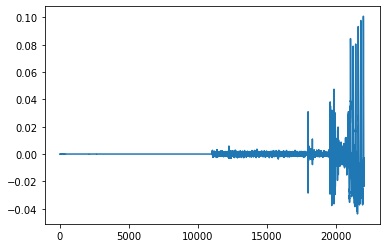

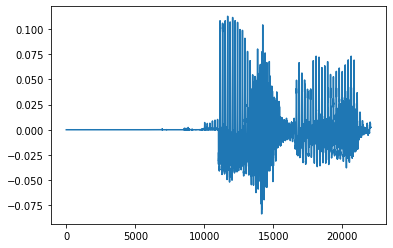

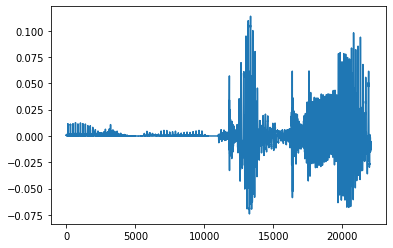

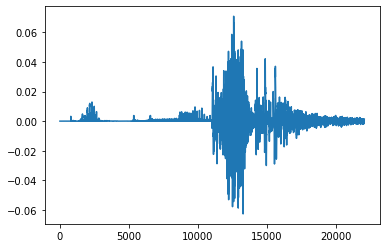

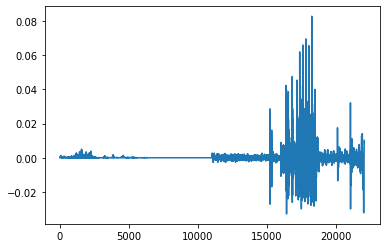

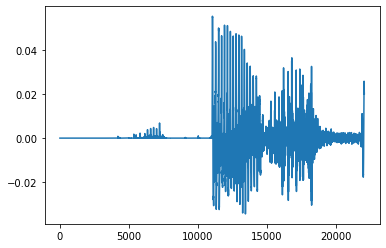

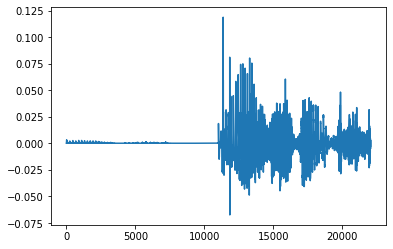

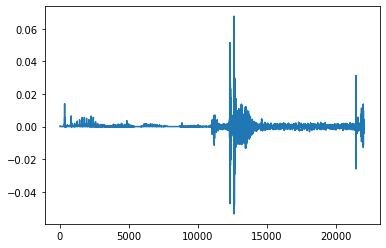

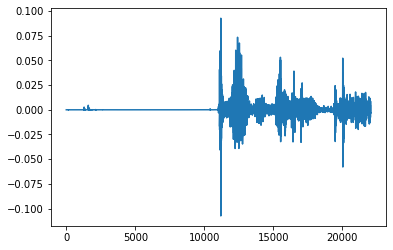

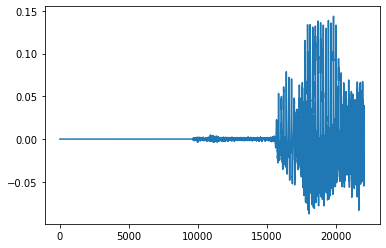

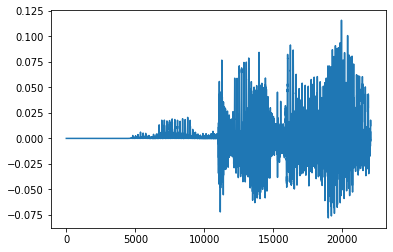

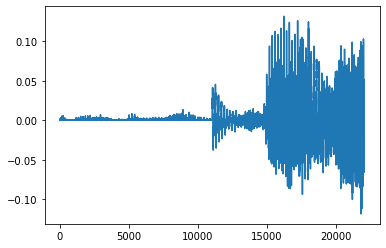

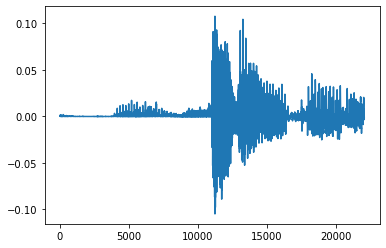

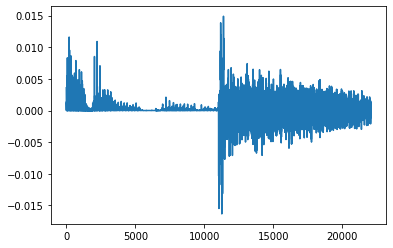

In [127]:
for k in range(19):
    pyplot.figure(k)
    pyplot.plot(chop[k])
    num = chop[k]
    for n in range(len(num)):
        num[n] = num[n]**2
    print(sum(num))

In [138]:
melgrams =  vs.ChopedSignalsToMelgrams()
for k in range(19):
    pyplot.figure(k)
    pyplot.imshow(melgrams[k], cmap='gist_heat', aspect ='auto')


AttributeError: 'VoiceSamples' object has no attribute 'ChopedSignalsToMelgrams'

In [94]:
print(vs[0])



None


In [95]:

smpl , sr = vs[33]
pyplot.plot(smpl)

TypeError: cannot unpack non-iterable NoneType object

In [37]:
import librosa as lr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import logging

from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot

 
logging.basicConfig(level=logging.INFO)
Log = logging.getLogger()

In [ ]:
class SoundSamples():
    

In [32]:
def LoadSoundSamples(coreName, samplesPath=None):
    
    n = 1
    soundSamples = [],[]
    
    while(True):
        try:
            if samplesPath:
                path = samplesPath + coreName + str(n)
            else:
                path = coreName + str(n)
                
            soundSample, sr = lr.load(path)
            
            n += 1
            soundSamples[0].append(soundSample)
            soundSamples[1].append(sr) 
            
            info = " Sample : " + path + " : successfully added"
            Log.info(info)
            
        except FileNotFoundError:
            if soundSamples[0]:
                info = "That's the end of database : " + str(n-1) + " : Samples added"
                Log.info(info)
                
                return soundSamples
            
            else:
                Log.exception("Files are missing")

            break
             
        except Exception as ex:      
            Log.exception("Unexpected error")
            break
            
            
            

In [33]:
def ChopToOneSecFragments(soundSample):
    
    soundSamples[0].append(soundSample)
    soundSamples[1].append(sr) 
    
    chopedSoundSamples = [],[]
    
    frag_max = math.trunc(len(soundSample)/float(sr))
    step = math.trunc(sr/2);
    last_sample = len(soundSample)
      
    for frag in range(frag_max*2):
        start = step * frag
        stop = start + sr
        if sr<len(soundSample):
            chopedSoundSamples[0].append(soundSample[start:stop])
            chopedSoundSamples[1].append(sr)
            info = "Sample : " + str(frag+1) + " : successfully choped and added"
            Log.info(info)
        else:
            Log.warning("Something went wrong")
        
     # incuding samples cuted by math.trunc() 
    chopedSoundSamples[0].append(soundSample[last_sample-sr:last_sample])
    chopedSoundSamples[1].append(sr)
    info = "Sample : " + str(frag_max*2+1) + " : successfully choped and added"
    Log.info(info)
            
    return chopedSoundSamples

In [ ]:
def AllChoped()

In [35]:
sampleList = LoadSoundSamples("vs")
if(sampleList!=None):
    s_sample = sampleList[0][0]
    s_sr = sampleList[1][0] 
OneSecSamples =  ChopToOneSecFragments(s_sample, s_sr)
print(len(OneSecSamples))


/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
INFO:root: Sample : vs1 : successfully added
/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
INFO:root: Sample : vs2 : successfully added
/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
INFO:root:That's the end of database : 2 : Samples added
INFO:root:Sample : 1 : successfully choped and added
INFO:root:Sample : 2 : successfully choped and added
INFO:root:Sample : 3 : successfully choped and added
INFO:root:Sample : 4 : successfully choped and added
INFO:root:Sample : 5 : successfully choped and add

2


In [40]:
print(len(OneSecSamples[0]))

19


In [67]:
def Tabbb():
    t = 4
    g = 7
    return t,g

h = Tabbb()

print(h)

(4, 7)
